# Working with Data wizard - using some of the polygon queries. 

Data Wizard is the new python API way to interact with instance of apertureDB.

It tries to avoid the need to know the details of the native query mechanism

It is still under development, so not all the capabilities of native query would be available.



## Simplest query.

### Using native Query

In [ ]:
from aperturedb import Connector
from aperturedb.Images import Images

db = Connector.Connector(user="admin", password="admin", port=55557)

min_size = 100000

limit = 10

query = [
    { "FindPolygon": {
        "_ref": 1,
        "with_label": "dog",
        "constraints": {
            "_area": [">", float(min_size)],
            "source": ["==", "coco"],
        },
        "areas": True,
        "results": {
            "sort": {
                "key": "_area",
                "order": "descending"
            },
            "list": ["ann_id"],
            "count": True,
        }
    }}]

responses, _ = db.query(query)
print(responses)


### Using Datawizard API

In [ ]:
from aperturedb import Connector
from aperturedb.Constraints import Constraints
from aperturedb.Sort import Sort, Order
from aperturedb.Entities import Query, Entities, EntityType
from aperturedb.Polygons import Polygons

db = Connector.Connector(user="admin", password="admin", port=55557)

con = Constraints()
con.greater("_area", 100000.0)
con.equal("source", "coco")
con.equal("_label", "dog")

sort = Sort(key="_area", order=Order.DESCENDING)

results = Polygons.retrieve(db=db, spec=Query.spec(
    constraints=con,
    sort=sort,
    list=["ann_id", "_area"]))

print(f"results={results}")
results.inspect()


## Filter and sort regions by their properties

This example is looking for high-resolution images of dogs.

It searches for polygon regions labeled "dog", and displays them in descending order by size (in pixels).  

### Using native Query

In [ ]:
from aperturedb import Connector, Images
from aperturedb.Constraints import Constraints

db = Connector.Connector(user="admin", password="admin", port=55557)

min_size = 100000

limit = 10

query = [
    { "FindPolygon": {
        "_ref": 1,
        "with_label": "dog",
        "constraints": {
            "_area": [">", float(min_size)],
            "source": ["==", "coco"],
        },
        "areas": True,
        "results": {
            "sort": {
                "key": "_area",
                "order": "descending"
            },
            "list": ["ann_id"],
            "count": True,
        }
    }},
    { "FindImage": {
        "is_connected_to": {
            "ref": 1,
            "connection_class": "_PolygonToImage"
        },
        "results": {
            "list": ["id"],
            "limit": limit,
        },
        "blobs": False,
    }}
]

responses, _ = db.query(query)

polygon_entities = responses[0]["FindPolygon"]["entities"][:limit]
image_entities = responses[1]["FindImage"]["entities"]

print("Found {} dogs larger than {} pixels".format(responses[0]["FindPolygon"]["count"], min_size))

imgs  = Images.Images(db)
img_ids = [img["id"] for img in image_entities]
imgs.search_by_id(img_ids)

plgn_ids = [plgn["ann_id"] for plgn in polygon_entities]
poly_const = Constraints()
poly_const.is_in("ann_id", plgn_ids)

print("displaying the top {}".format(len(img_ids)))

imgs.display(polygon_constraints=poly_const, polygon_tag_key="_area", polygon_tag_format="{:.0f} pixels")


### Using DataWizard API

query=[{'FindEntity': {'_ref': 1, 'results': {'sort': {'key': '_area', 'order': 'descending'}, 'list': ['ann_id']}, 'with_class': '_Polygon', 'constraints': {'all': {'_area': ['>', 100000.0], 'source': ['==', 'coco'], '_label': ['==', 'dog']}}}}, {'FindEntity': {'_ref': 2, 'results': {'list': ['id']}, 'with_class': '_Image', 'is_connected_to': {'ref': 1}}}]
Index is incorrect
Index is incorrect
Index is incorrect
Index is incorrect
Index is incorrect
Index is incorrect
Index is incorrect
Index is incorrect
Index is incorrect
Index is incorrect
results=<aperturedb.Images.Images object at 0x7f3904c16610>


,id,polygons
0,131273,<aperturedb.Polygons.Polygons object at 0x7f39...
1,520301,<aperturedb.Polygons.Polygons object at 0x7f39...
2,283412,<aperturedb.Polygons.Polygons object at 0x7f39...
3,361571,<aperturedb.Polygons.Polygons object at 0x7f39...
4,498286,<aperturedb.Polygons.Polygons object at 0x7f39...


IntSlider(value=100, max=400, min=1)

Output()

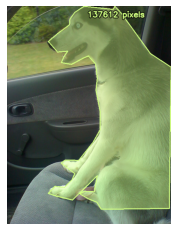

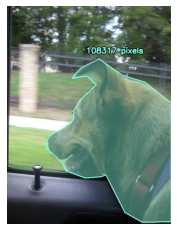

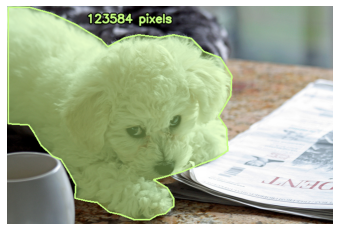

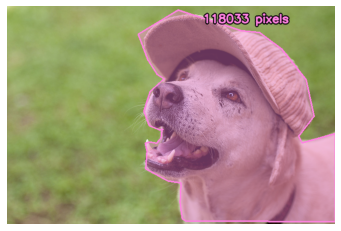

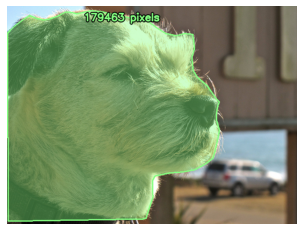

In [1]:
import base64
from io import BytesIO
from pprint import pprint
from aperturedb import Connector
from aperturedb.Images import Images
from aperturedb.Constraints import Constraints
from aperturedb.Sort import Sort, Order
from aperturedb.Entities import Entities, Query, EntityType
from IPython.display import display, HTML
import pandas as pd
from ipywidgets import widgets

db = Connector.Connector(user="admin", password="admin", port=55557)

con = Constraints()
con.greater("_area", 100000.0)
con.equal("source", "coco")
con.equal("_label", "dog")

sort = Sort(key="_area", order=Order.DESCENDING)
spec_polygons = Query.spec(with_class=EntityType.POLYGON, constraints=con, sort=sort, list=["ann_id"])

results = Images.retrieve(db=db, spec=Query.spec(list=["id"]), with_adjacent = {
    "polygons": spec_polygons
})

img_ids = [img["id"] for img in results]
results.search_by_id(img_ids)
print(f"results={results}")

display(results.inspect())
a, b = results.inspect(get_visual=True)
display(a, b)

#TODO : Since the result has both the collections already, can
# extra querying be avoided?
polygon_ids = [polygon["ann_id"] for polygons in results for polygon in polygons["polygons"]]
poly_const = Constraints()
poly_const.is_in("ann_id", polygon_ids)

#TODO : make this implicit
results.display(polygon_constraints=poly_const, polygon_tag_key="_area", polygon_tag_format="{:.0f} pixels")


In [ ]:
results

## Find overlapping regions

This example is looking for images of people wearing neckties. 

It searches for images that contain a polygon region labled "person" that intersects with a polygon labeled "tie".  

### Using native Query

In [ ]:
from aperturedb import Connector, Images, ParallelQuery

db = Connector.Connector("localhost", user="admin", password="admin", port=55557)

find_images_with_ties_query = [
    { "FindPolygon": {
        "_ref": 1,
        "with_label": "tie",
        "constraints": {
            "source": ["==", "coco"],
        },
    }},
    { "FindImage": {
        "is_connected_to": {
            "ref": 1,
            "connection_class": "_PolygonToImage"
        },
        "results": {
            "list": ["id"],
            "limit": 100,
        },
        "blobs": False
    }}
]

responses, _ = db.query(find_images_with_ties_query)

img_ids = [ent["id"] for ent in responses[1]["FindImage"]["entities"]]

find_overlaps_query = []
for idx, img_id in enumerate(img_ids):
    img_ref = (3*idx) + 1
    tie_ref = img_ref + 1
    person_ref = tie_ref + 1
    find_overlaps_query.extend([
        { "FindImage": {
            "_ref": img_ref,
            "constraints": {
                "id": ["==", img_id],
            },
            "blobs": False
        }},
        { "FindPolygon": {
            "_ref": tie_ref,
            "image_ref": img_ref,
            "with_label": "tie",
            "constraints": {
                "source": [ "==", "coco" ],
            },
            "results": {
                "list": [ "ann_id" ],
            },
        }},
        { "FindPolygon": {
            "_ref": person_ref,
            "image_ref": img_ref,
            "with_label": "person",
            "constraints": {
                "source": [ "==", "coco" ],
            },
            "results": {
                "list": [ "ann_id" ],
            },
        }},
        { "RegionIoU": {
            "roi_1": tie_ref,
            "roi_2": person_ref,
        }}
    ])

responses, _ = db.query(find_overlaps_query)

display_img_ids = []
overlapping_polygon_ids = []
for idx, img_id in enumerate(img_ids):
    tie_res_idx = (4*idx)+1
    person_res_idx = tie_res_idx + 1
    iou_res_idx = person_res_idx + 1
    ties = responses[tie_res_idx]["FindPolygon"]["entities"]
    if "entities" in responses[person_res_idx]["FindPolygon"]:
        people = responses[person_res_idx]["FindPolygon"]["entities"]
        iou_mtx = responses[iou_res_idx]["RegionIoU"]["IoU"]
        found_overlap = False
        for ti, iou_row in enumerate(iou_mtx):
            for pi, iou in enumerate(iou_row):
                if iou > 0.001:
                    overlapping_polygon_ids.append(people[pi]["ann_id"])
                    overlapping_polygon_ids.append(ties[ti]["ann_id"])
                    found_overlap = True
        if found_overlap:
            display_img_ids.append(img_id)

imgs  = Images.Images(db)
imgs.search_by_id(display_img_ids)

is_person_with_tie = Images.Constraints()
is_person_with_tie.is_in("ann_id", overlapping_polygon_ids)

imgs.display(polygon_constraints=is_person_with_tie)

### Using Datawizard API

In [ ]:
from aperturedb import Connector
from aperturedb.Images import Images
from aperturedb.Constraints import Constraints, Conjunction
from aperturedb.Sort import Sort, Order
from aperturedb.Entities import Entities, Query, EntityType
from IPython.display import display

db = Connector.Connector(user="admin", password="admin", port=55557)

con = Constraints()
con.equal("source", "coco")
con.equal("_label", "tie")

results = Images.retrieve(db=db, spec=Query.spec(list=["id"], limit=100), with_adjacent = {
    "ties": Query.spec(with_class=EntityType.POLYGON, constraints=con)
})

print(f"results={results}")
display(results.inspect())

images = results

# images.pre_process()
poly_con = Constraints()
poly_con.equal("source", "coco")
poly_con.is_in("_label", ["tie", "person"])


result = images.get_connected_entities("id", EntityType.POLYGON, poly_con)


overlapping_polygon_ids = []
for i, polygons in enumerate(result):
    ties = polygons.filter(lambda p: p["_label"] == "tie")
    persons = polygons.filter(lambda p: p["_label"] == "person")
    if i < 3:
        print(f"ties={ties}, persons = {persons}")
        display(ties.inspect())
        display(persons.inspect())
    overlapping = ties.intersection(persons, threshold=0.001)
    overlapping_polygon_ids.extend(overlapping)
    
   

drawables_constraints = Constraints()
drawables_constraints.is_in("ann_id", overlapping_polygon_ids)

images.display(polygon_constraints=drawables_constraints)
# images.display()


In [ ]:
# result[1].inspect()
images[0]

## Find objects in a fixed location

This example is looking for images with trains in the upper left corner.

It searches for images with polygon regions labeled "train" that intersect an ad hoc polygon in the upper left corner (displayed in red).

In [ ]:
from aperturedb import Connector, Images

db = Connector.Connector("localhost", user="admin", password="admin")

upper_left_corner_region = [
    [0.0, 0.0],
    [100.0, 0.0],
    [95.0, 5.0],
    [40.0, 5.0],
    [5.0, 40.0],
    [5.0, 95.0],
    [0.0, 100.0],
]

find_train_regions_query = [
    { "FindPolygon": {
        "_ref": 1,
        "with_label": "train",
        "constraints": {
            "source": ["==", "coco"],
        },
        "results": {
            "list": [ "ann_id", "image_id" ],
        },
    }},
    { "RegionIoU": {
        "roi_1": 1,
        "polygons": [upper_left_corner_region], 
    }}
]

responses, _ = db.query(find_train_regions_query)

num_trains = responses[0]["FindPolygon"]["returned"]
train_entities = responses[0]["FindPolygon"]["entities"]
print("total train regions: {}".format(num_trains))

iou_mtx = responses[1]["RegionIoU"]["IoU"]
upper_left_train_ids = []
image_ids = []
for i in range(num_trains):
    if iou_mtx[i][0] > 0:
        train = train_entities[i]
        upper_left_train_ids.append(train["ann_id"])
        if train["image_id"] not in image_ids:
            image_ids.append( train["image_id"] )
    
print("trains in upper left: {}".format(len(upper_left_train_ids)))

imgs  = Images.Images(db)
imgs.search_by_id(image_ids)
imgs.add_polygon_overlay([upper_left_corner_region],(0,0,255))

upper_left_trains = Images.Constraints()
upper_left_trains.is_in("ann_id", upper_left_train_ids)

imgs.display(polygon_constraints=upper_left_trains)

## Evaluating an Object Detector

This demo is evaluating polygons generated by an object detector against ground truth data.

For a given image and object category, it identifies all ground truth and detected regions and generates the matrix of pairwise intersection-over-union (IoU) values.

In [ ]:
from aperturedb import Connector, Images

db = Connector.Connector(port=55557, user="admin", password="admin")

IMAGE_ID = 192

imgs = Images.Images(db)
imgs.search_by_id([IMAGE_ID])

query = [
    { "FindImage": {
        "_ref": 1,
        "constraints": {
            "id": [ "==", IMAGE_ID ],
        },
        "unique": True,
        "blobs": False,
    }},
    { "FindPolygon": {
        "_ref": 2,
        "image_ref": 1,
        "constraints": {
            "source": [ "==", "coco" ],
        },
        "labels": True,
        "results": {
            "list": ["ann_id"],
        },
    }},
    { "FindPolygon": {
        "_ref": 3,
        "image_ref": 1,
        "constraints": {
            "source": [ "==", "detected" ],
        },
        "labels": True,
        "results": {
            "list": ["ann_id"],
        },
    }},
    { "RegionIoU": {
        "roi_1": 2,
        "roi_2": 3,
    }}
]

responses, _ = db.query(query)

ground_truth_categories = [ gt["_label"] for gt in responses[1]["FindPolygon"]["entities"] ]
detected_categories = [ dt["_label"] for dt in responses[2]["FindPolygon"]["entities"] ]
iou_matrix = responses[3]["RegionIoU"]["IoU"]

TEXT_COLOR = (255,255,255)

gt_polys = Images.Constraints()
gt_polys.equal("source", "coco")
imgs.clear_overlays()
imgs.add_text_overlay("GROUND TRUTH POLYGONS", (20,40), TEXT_COLOR)
imgs.display(polygon_constraints=gt_polys)

dt_polys = Images.Constraints()
dt_polys.equal("source", "detected")
imgs.clear_overlays()
imgs.add_text_overlay("DETECTED POLYGONS", (20,40), TEXT_COLOR)
imgs.display(polygon_constraints=dt_polys)

print("\nIoU matrix for polygons in image {}:".format(IMAGE_ID))
cell_width = max([len(lbl) for lbl in ground_truth_categories])
cell = "{: ^" + str(cell_width) + "}"
print("|".join([cell.format("GT \ DT")] + [cell.format(cat) for cat in detected_categories]))
for i, row in enumerate(iou_matrix):
    print("|".join([cell.format(ground_truth_categories[i])] + [cell.format("{:.4f}".format(id)) for id in row]))


## Polygon Levels of Detail

`FindPolygon` can be used to retrieve polygon geometry at the following levels of detail, from least to most complex:
- `bounds`: Returns the smallest axis-aligned bounding box that contains each polygon in the region.
- `hulls`: Returns the smallest ***convex*** polygon that contains each polygon in the region.
- `vertices`: Returns the full-resolution polygon geometry exactly as it was added.
- `decompositions`: Returns a breakdown of the region into convex pieces.

This demo shows all available levels of detail for a single polygon region.

In [ ]:
from aperturedb import Connector, Images

db = Connector.Connector("aperturedb.local", user="admin", password="admin")

POLYGON_ID = 226510

query = [
    { "FindPolygon": {
        "_ref": 1,
        "constraints": {
            "ann_id": ["==", POLYGON_ID],
        },
        "unique": True,
        "bounds": True,
        "hulls": True,
        "vertices": True,
        "decompositions": True,
    }},
    { "FindImage": {
        "is_connected_to": {
            "ref": 1,
            "connection_class": "_PolygonToImage"
        },
        "unique": True,
        "results": {
            "list": ["id"],
        },
        "blobs": False
    }}
]

responses, _ = db.query(query)

polygon_result = responses[0]["FindPolygon"]["entities"][0]
img_id = responses[1]["FindImage"]["entities"][0]["id"]

imgs  = Images.Images(db)
imgs.search_by_id([img_id])

BOUNDS_COLOR = (128,128,255) # red
HULL_COLOR = (128,255,255) # yellow
VERTS_COLOR = (128,255,128) # green
DECOMP_COLOR = (255,128,128) # blue

bounds = polygon_result["_bounds"]
imgs.add_bbox_overlay(bounds, BOUNDS_COLOR)
imgs.add_polygon_overlay(polygon_result["_hulls"], HULL_COLOR)
imgs.add_polygon_overlay(polygon_result["_decompositions"], DECOMP_COLOR, 0.2)
imgs.add_polygon_overlay(polygon_result["_vertices"], VERTS_COLOR, 0.0)

TEXT_OFFSET = 32
x = bounds["x"] + bounds["width"] + TEXT_OFFSET
y = bounds["y"] + TEXT_OFFSET

for text, color in {
    "bounds": BOUNDS_COLOR,
    "hulls": HULL_COLOR,
    "vertices": VERTS_COLOR,
    "decompositions": DECOMP_COLOR,
}.items():
    imgs.add_text_overlay(text, (x, y), color)
    y += TEXT_OFFSET

imgs.display()

In [ ]:
# pd.json_normalize(responses[0]["FindPolygon"]["entities"])
images = Images.retrieve(db, limit=10)
images.inspect()
images.display(show_polygons=True)


In [ ]:
import pandas as pd

a = [{
    "a": 1,
    "b": 2,
    "c": [
        {"d": 5, "e": 6},
        {"d": 7, "e": 8}
    ]
}, {
    "a": 3,
    "b": 4,
    "c": [
        {"d": 5, "e": 6},
        {"d": 7, "e": 8}
    ]
}]

pd.json_normalize(a, record_path=["c"], meta=['a', 'b'])